In [2]:
import pandas as pd
import numpy as np
from trails.read_data import get_obs_state_dct
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
from trails.optimizer import post_prob
%load_ext rpy2.ipython

n_sites = 200000

/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ILS = 32

t_A = 200000/200
t_B = 200000/200
t_1 = max([t_A, t_B])
N_AB = 80000/200
t_2 = -N_AB*np.log(3/2*ILS/100)
t_C = t_1+t_2
N_ABC = 70000/200
t_3 = t_1*5
r = 0.5e-8*200
mu = 1.5e-8*200

# t_A = 1900
# t_B = 1900
# t_1 = max([t_A, t_B, t_C])
# N_AB = 500
# t_2 = t_1+t_2
# t_C = 1900
# N_ABC = 500
# t_3 = 8000
# r = 2e-6
# mu = 0.5e-6

n_int_AB = 5
n_int_ABC = 7

N_ref = N_ABC

t_out = t_1+t_2+t_3+2*N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)

(2/3)*(np.exp(-t_2/(N_AB)))

cut_ABC

array([1293.58767003, 1347.54040797, 1411.35295285, 1489.45319581,
       1590.14192117, 1732.05470901, 1974.6562222 ,           inf])

## Plots

In [4]:
%%R

library(tidyverse)

hid_tab_second <- read_csv('../results/hid_tab_second.csv', show_col_types = FALSE)
tree_tab_second <- read_csv('../results/tree_tab_second.csv', show_col_types = FALSE)
post_tab_second <- read_csv('../results/post_tab_second.csv', show_col_types = FALSE)
hid_tab_first <- read_csv('../results/hid_tab_first.csv', show_col_types = FALSE)
tree_tab_first <- read_csv('../results/tree_tab_first.csv', show_col_types = FALSE)
post_tab_first <- read_csv('../results/post_tab_first.csv', show_col_types = FALSE)

post_tab_neutral <- read_csv('../../simulated_posterior/data/post_tab.csv', show_col_types = FALSE)
tree_tab_neutral <- read_csv('../../simulated_posterior/data/tree_tab.csv', show_col_types = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
%%R -w 2000 -h 700 -r 150 -i n_int_AB

# p1 <- post_tab_first %>%
#     mutate(is_V0 = topology == 0) %>%
#     group_by(pos, is_V0, int_1) %>%
#     summarize(prob = sum(value)) %>%
#     ggplot() +
#     geom_tile(aes(pos, int_1+(!is_V0)*(n_int_AB+0.1), fill = prob, color = prob)) +
#     geom_segment(aes(x = start, xend = end, y = int_1+(!(topology == 0))*(n_int_AB+0.1), yend = int_1+(!(topology == 0))*(n_int_AB+0.1)), 
#                  color = 'red',
#                  data = tree_tab_first) +
#     scale_fill_viridis_c(limits=c(0,1)) +
#     scale_color_viridis_c(limits=c(0,1)) +
#     scale_x_continuous(expand = c(0, 0)) +
#     scale_y_continuous(expand = c(0, 0)) +
#     labs(y = 'First coalescent', x = 'Position')
#     
# p1

NULL


`summarise()` has grouped output by 'pos'. You can override using the `.groups`
argument.


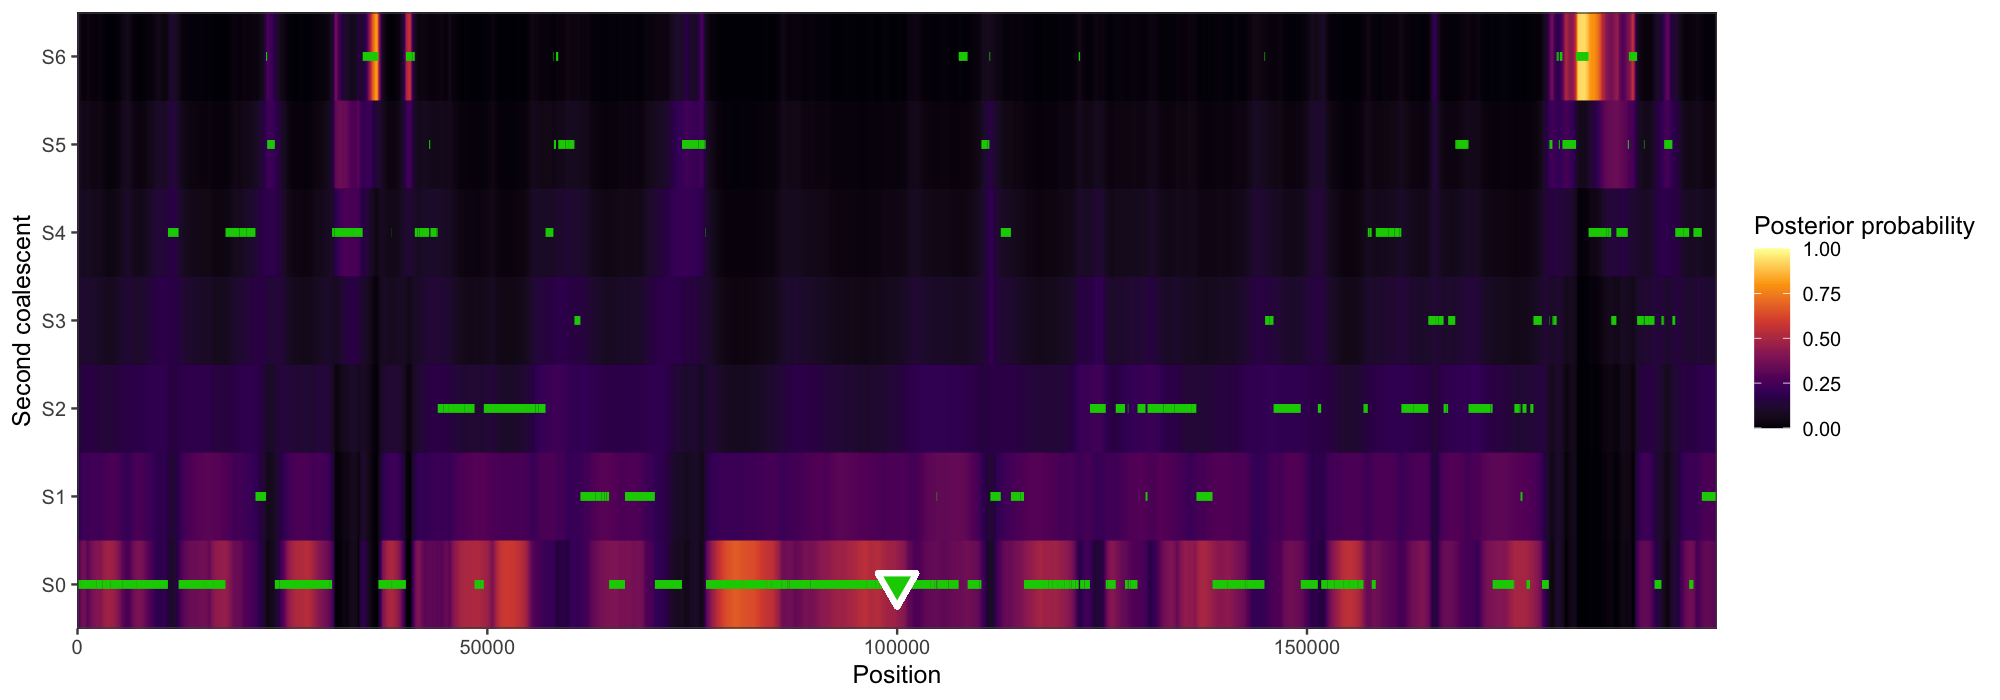

In [13]:
%%R -w 2000 -h 700 -r 150  -i n_int_AB -i n_int_ABC

library(ggthemes)

p2 <- post_tab_second %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_2, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2), 
                 color = 'green3', size = 2,
                 data = tree_tab_second) +
    geom_point(aes(100000, 0), shape = 25, color = 'white', fill = 'green3', size = 5, stroke = 2) +
    scale_fill_viridis_c(
        name = 'Posterior probability',
        limits=c(0,1), 
        option="inferno", 
        # trans = 'log'
        ) +
    scale_color_viridis_c(
        name = 'Posterior probability',
        limits=c(0,1), 
        option="inferno", 
        # trans = 'log'
        ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0),
                       breaks = 0:(n_int_ABC-1), 
                       labels = paste0('S', 0:(n_int_ABC-1))
                      ) +
    labs(y = 'Second coalescent', x = 'Position') +
    theme_few() 

p2

In [7]:
%%R -w 2000 -h 700 -r 150

# p3 <- post_tab_second %>%
#     group_by(pos, topology) %>%
#     summarize(prob = sum(value)) %>%
#     ggplot() +
#     geom_tile(aes(pos, topology, fill = prob, color = prob)) +
#     geom_segment(aes(x = start, xend = end, y = topology, yend = topology), 
#                  color = 'red',
#                  data = tree_tab_second) +
#     scale_fill_viridis_c(limits=c(0,1)) +
#     scale_color_viridis_c(limits=c(0,1)) +
#     scale_x_continuous(expand = c(0, 0)) +
#     scale_y_continuous(expand = c(0, 0)) +
#     labs(y = 'Topology') +
#     theme(
#         axis.title.x = element_blank(),
#         axis.text.x = element_blank(),
#         axis.ticks.x=element_blank()
#     )
# 
# p3

NULL


In [11]:
%%R -i n_int_ABC -i n_sites

library(tidyverse)

# int_2_tab_true <- tibble()
# int_2_tab_post2 <- tibble()
# for (i in 10:29) {
#     print(i)
#     int_2_tab_post2 <- bind_rows(int_2_tab_post2, 
#         read_csv(paste0('../results/replicates/post_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, pos) %>%
#         filter(prob == max(prob)) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = n()/n_sites,
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
#     int_2_tab_true <- bind_rows(int_2_tab_true, 
#         read_csv(paste0('../results/replicates/tree_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = sum(end-start)/n_sites, .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Empirical'))
# }

int_2_tab_true <- read_csv('int_2_tab_true.csv')
int_2_tab_post2 <- read_csv('int_2_tab_post2.csv')

Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
%%R -i n_int_ABC -i n_sites

int_2_tab_theo <- tibble(
    int_2 = 0:(n_int_ABC-1),
    suma = 1/n_int_ABC,
    Type = 'Theoretical'
)

# write_csv(int_2_tab_true, 'int_2_tab_true.csv')
# write_csv(int_2_tab_post2, 'int_2_tab_post2.csv')

summary_table <- bind_rows(
    int_2_tab_true, 
    int_2_tab_post2 
    ) %>% 
    group_by(int_2, Type) %>%
    summarize(m = mean(suma))


`summarise()` has grouped output by 'int_2'. You can override using the
`.groups` argument.


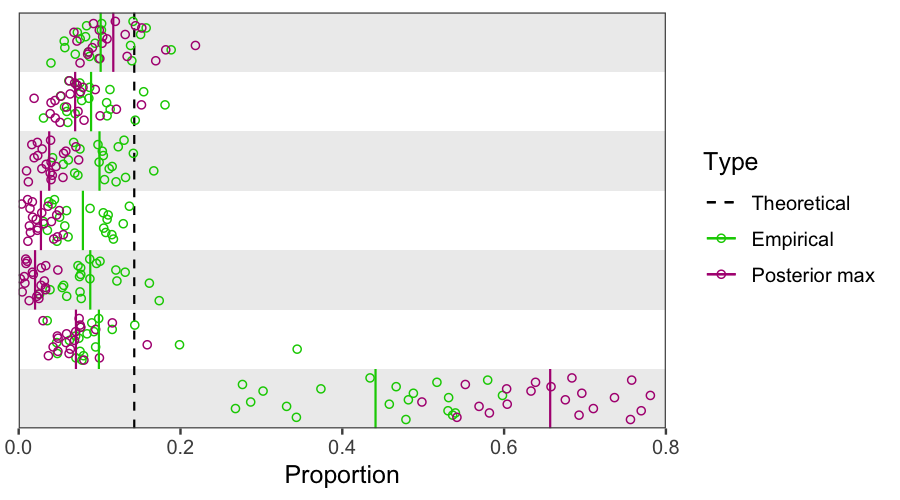

In [15]:
%%R -w 900 -h 500 -r 150 

library(ggthemes)

plot_post_binned <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true, 
    int_2_tab_post2, 
    # int_2_tab_theo
    ) %>%
    mutate(Type = factor(Type, (c('Empirical', 'Posterior mean', 'Posterior max')))) %>% 
    ggplot() +
    # geom_vline(aes(xintercept = x), data = tibble(x = 0:n_int_ABC), color = 'grey80') +
    geom_rect(aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf), 
              data = tibble(xmin = seq(0, n_int_ABC, 2), xmax = seq(1, n_int_ABC, 2)), fill = 'grey93') +
    geom_hline(aes(yintercept = 1/n_int_ABC, color = 'Theoretical'), linetype = 2) +
    # geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    geom_point(aes(int_2+((nsim-10)/20-0)/(0.95-0)*(0.85-0.15)+0.15, suma, color = Type), shape = 21) +
    geom_segment(aes(x = int_2, xend = int_2+1, y= m, yend = m, color = Type), data = summary_table) +
    # geom_segment(aes(x = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  xend = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  y = 0, yend = suma, color = Type)) +
    theme_few() +
    labs(x = 'Second coalescent bin', y = 'Proportion') +
    scale_x_continuous(
        # breaks = 0:(n_int_ABC-1), 
        expand = c(0, 0),
        limits = c(0, n_int_ABC),
        breaks = 0:n_int_ABC
    ) +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 0.8)
    ) +
    scale_color_manual(
        name = 'Type',
        values = c('black', 'green3', '#b01e81'), 
        breaks = c('Theoretical', 'Empirical', 'Posterior max')) +
    theme(
        axis.title.y = element_blank(),
        # legend.position = c(0.7, 0.6),
        # legend.position = 'bottom',
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    coord_flip()+
    guides(color = guide_legend(override.aes = list(linetype = c(2, 1, 1), shape = c(NA, 21, 21)) ) )
    
plot_post_binned

In [19]:
%%R -w 2000 -h 500 -r 150 

library(patchwork)

(p2 | plot_post_binned) + plot_layout(widths = c(10, 4), guides = 'collect')

ggsave(paste0('../plots/posterior_decoding_selection_replicates.tiff'), width = 14, height = 14/4)
# ggsave(paste0('../plots/posterior_decoding_selection.pdf'), width = 14, height = 14/4)

In [4]:
%%R -i n_int_ABC 

n_sites_neutral <- 100000

# int_2_tab_post <- post_tab %>%
#     group_by(pos, int_2) %>%
#     summarize(prob = sum(value)) %>%
#     group_by(int_2) %>%
#     summarize(
#         suma = sum(prob)/n_sites
#     ) %>%
#     ungroup() %>%
#     arrange(desc(int_2)) %>%
#     mutate(Type = 'Posterior mean')
    
int_2_tab_post2 <- post_tab_neutral %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    group_by(pos) %>%
    filter(prob == max(prob)) %>%
    group_by(int_2) %>%
    summarize(
        suma = n()/n_sites_neutral
    ) %>%
    ungroup() %>%
    arrange(desc(int_2)) %>%
    mutate(Type = 'Posterior max')
    
int_2_tab_true <- tree_tab_neutral %>% 
    group_by(int_2) %>%
    summarize(
        suma = sum(end-start)/n_sites_neutral
    ) %>%
    ungroup() %>%
    arrange(desc(int_2)) %>%
    mutate(Type = 'Empirical')

int_2_tab_theo <- tibble(
    int_2 = 0:(n_int_ABC-1),
    suma = 1/n_int_ABC,
    Type = 'Theoretical'
)
    

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


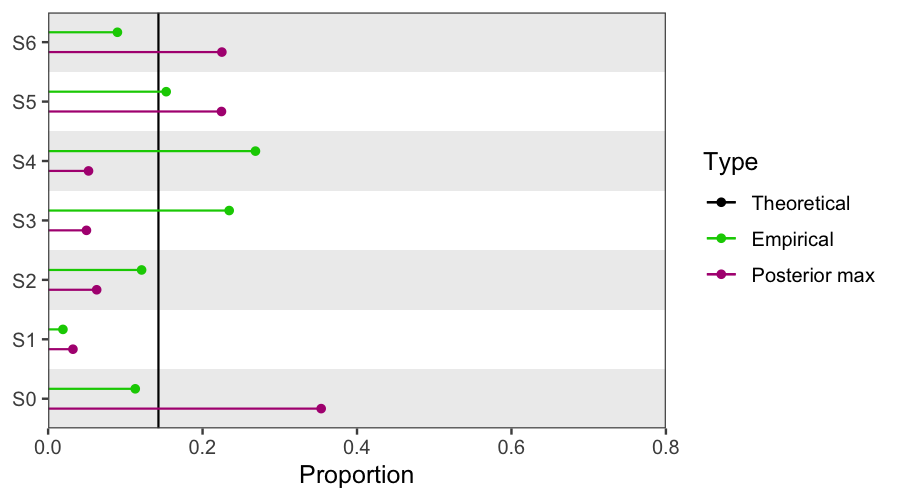

In [12]:
%%R -w 900 -h 500 -r 150 

library(ggthemes)

plot_post_binned <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true, 
    int_2_tab_post2, 
    # int_2_tab_theo
    ) %>%
    mutate(Type = factor(Type, (c('Empirical', 'Posterior mean', 'Posterior max')))) %>% 
    ggplot() +
    # geom_vline(aes(xintercept = x), data = tibble(x = 0:n_int_ABC), color = 'grey80') +
    geom_rect(aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf), 
              data = tibble(xmin = seq(0, n_int_ABC, 2), xmax = seq(1, n_int_ABC, 2)), fill = 'grey93') +
    geom_hline(aes(yintercept = 1/n_int_ABC, color = 'Theoretical')) +
    # geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    geom_point(aes(int_2+(Type=='Empirical')*1/3+1/3, suma, color = Type)) +
    geom_segment(aes(x = int_2+(Type=='Empirical')*1/3+1/3, 
                     xend = int_2+(Type=='Empirical')*1/3+1/3, 
                     y = 0, yend = suma, color = Type)) +
    theme_few() +
    labs(x = 'Second coalescent bin', y = 'Proportion') +
    scale_x_continuous(
        # breaks = 0:(n_int_ABC-1), 
        expand = c(0, 0),
        limits = c(0, n_int_ABC),
        breaks = 0:(n_int_ABC-1)+0.5,
        labels = paste0('S', 0:(n_int_ABC-1))
    ) +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 0.8)
    ) +
    scale_color_manual(
        name = 'Type',
        values = c('black', 'green3', '#b01e81'), 
        breaks = c('Theoretical', 'Empirical', 'Posterior max')) +
    theme(
        axis.title.y = element_blank(),
        # legend.position = c(0.7, 0.6),
        # legend.position = 'bottom',
        # axis.text.y = element_blank(),
        # axis.ticks.y = element_blank()
    ) +
    coord_flip()
    
plot_post_binned

In [13]:
%%R

ggsave('../plots/summary_neutral.pdf', plot_post_binned, width = 7, height = 14/4)